In [5]:
import os, sys
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *

from load_llff import load_llff_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False

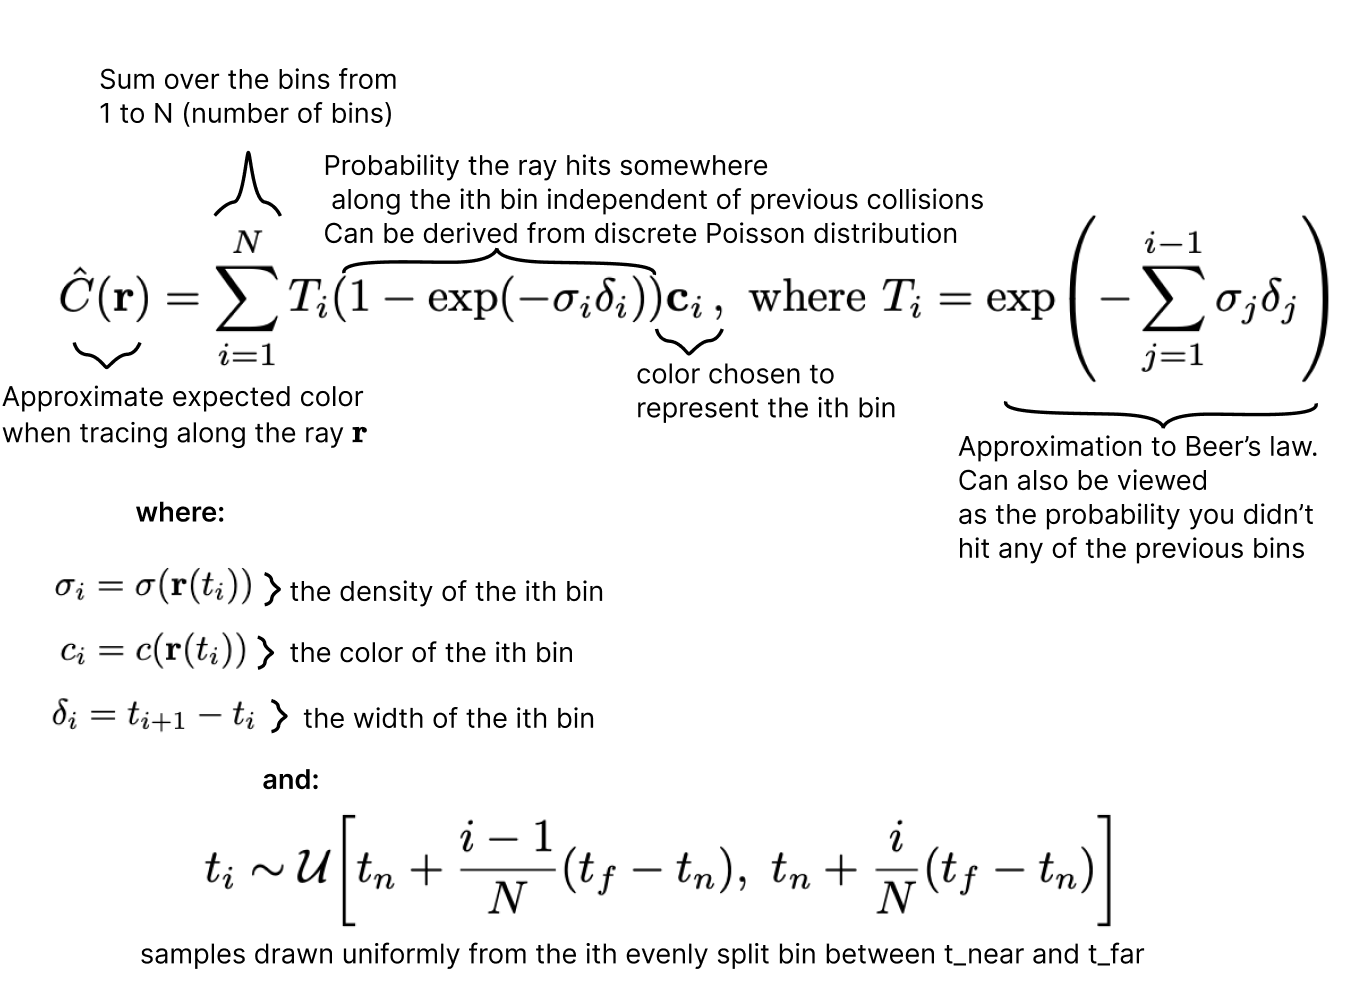

In [6]:
# python run_nerf.py --config configs/fern.txt

N_importance = 64
N_rand = 1024
N_samples = 64
basedir = './logs'
chunk = 1024*32
expname = 'fern_test'
datadir = './data/nerf_llff_data/fern'
dataset_type = 'llff'
factor = 8
ft_path = None
i_embed = 0
i_print = 100
i_testset = 50000
i_video = 50000
i_weights = 10000
lindisp = True
llffhold = 8
lrate = 5e-4
lrate_decay = 250
multires = 10
multires_views = 4
netchunk = 1024*64
netdepth = 8
netdepth_fine = 8
netwidth = 256
netwidth_fine = 256
no_batching = True
no_ndc = True
no_reload = True
perturb = 1.0
precrop_frac = 0.5
precrop_iters = 0
raw_noise_std = 0.0
render_factor = 0
render_only = False
render_test = True
spherify = True
use_viewdirs = True
white_background = True



In [7]:
N_importance = 64
N_rand = 1024
N_samples = 64
basedir = './logs'
chunk = 32768
config = 'configs/fern.txt'
datadir = './data/nerf_llff_data/fern'
dataset_type = 'llff'
expname = 'fern_test'
factor = 8
ft_path = None
half_res = False
i_embed = 0
i_img = 500
i_print = 100
i_testset = 50000
i_video = 50000
i_weights = 10000
lindisp = False
llffhold = 8
lrate = 0.0005
lrate_decay = 250
multires = 10
multires_views = 4
netchunk = 65536
netdepth = 8
netdepth_fine = 8
netwidth = 256
netwidth_fine = 256
no_batching = False
no_ndc = False
no_reload = False
perturb = 1.0
precrop_frac = 0.5
precrop_iters = 0
raw_noise_std = 1.0
render_factor = 0
render_only = False
render_test = False
shape = 'greek'
spherify = False
testskip = 8
use_viewdirs = True
white_background = False

In [8]:
'''
>>> x = torch.randn(2, 3)
>>> x
tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
>>> torch.cat((x, x, x), 0)
tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
>>> torch.cat((x, x, x), 1)
tensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,
         -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,
         -0.5790,  0.1497]])
'''

def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

def run_network(inputs, view_direction, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'.
    """
    
    # [DONE] fn = model
    # [NOT] pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # -1 is the last one
    
    # [NOT]  embad the position
    embedded = embed_fn(inputs_flat)

    if view_direction is not None:
        input_dirs = view_direction[:,None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1)

    outputs_flat = batchify(fn, netchunk)(embedded)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    return outputs

def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret


def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps




def create_nerf():
    """Instantiate NeRF's MLP model.
    """
    #########################################################################
    # python run_nerf.py --config configs/fern.txt
    N_importance = 64
    N_rand = 1024
    N_samples = 64
    basedir = './logs'
    chunk = 32768
    config = 'configs/fern.txt'
    datadir = './data/nerf_llff_data/fern'
    dataset_type = 'llff'
    expname = 'fern_test'
    factor = 8
    ft_path = None
    half_res = False
    i_embed = 0
    i_img = 500
    i_print = 100
    i_testset = 50000
    i_video = 50000
    i_weights = 10000
    lindisp = False
    llffhold = 8
    lrate = 0.0005
    lrate_decay = 250
    multires = 10
    multires_views = 4
    netchunk = 65536
    netdepth = 8
    netdepth_fine = 8
    netwidth = 256
    netwidth_fine = 256
    no_batching = False
    no_ndc = False
    no_reload = False
    perturb = 1.0
    precrop_frac = 0.5
    precrop_iters = 0
    raw_noise_std = 1.0
    render_factor = 0
    render_only = False
    render_test = False
    shape = 'greek'
    spherify = False
    testskip = 8
    use_viewdirs = True
    white_background = False

    ################################################################################

    
    
    
    
    
    
    
    
    embed_fn, input_ch = get_embedder(multires, i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(multires_views, i_embed)
    output_ch = 5 if N_importance > 0 else 4
    skips = [4]
    model = NeRF(D=netdepth, W=netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if N_importance > 0:
        model_fine = NeRF(D=netdepth_fine, W=netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=netchunk)

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=lrate, betas=(0.9, 0.999))

    start = 0
    basedir = basedir
    expname = expname

    ##########################

    # Load checkpoints
    if ft_path is not None and ft_path!='None':
        ckpts = [ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : perturb,
        'N_importance' : N_importance,
        'network_fine' : model_fine,
        'N_samples' : N_samples,
        'network_fn' : model,
        'use_viewdirs' : use_viewdirs,
        'white_background' : white_background,
        'raw_noise_std' : raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if dataset_type != 'llff' or no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer




def raw2outputs(raw, z_vals, rays_direction, raw_noise_std=0, white_background=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_direction: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disparity_map: [num_rays]. Disparity map. Inverse of depth map.
        accumulated_opacity_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    raw2alpha = lambda raw, distances, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*distances)

    distances = z_vals[...,1:] - z_vals[...,:-1]
    distances = torch.cat([distances, torch.Tensor([1e10]).expand(distances[...,:1].shape)], -1)  # [N_rays, N_samples]

    distances = distances * torch.norm(rays_direction[...,None,:], dim=-1)

    rgb = torch.sigmoid(raw[...,:3])  # [N_rays, N_samples, 3]
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape) * raw_noise_std

        # Overwrite randomly sampled data if pytest
        if pytest:
            np.random.seed(0)
            noise = np.random.rand(*list(raw[...,3].shape)) * raw_noise_std
            noise = torch.Tensor(noise)

    alpha = raw2alpha(raw[...,3] + noise, distances)  # [N_rays, N_samples]
    # weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    # tensor = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float)
    # cumprod_tensor = torch.cumprod(tensor, dim=0)
    # tensor([1., 2., 6., 24., 120.])
    # torch.cumprod() is Ti of all the point
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    rgb_map = torch.sum(weights[...,None] * rgb, -2)  # [N_rays, 3]

    depth_map = torch.sum(weights * z_vals, -1)
    disparity_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1))
    accumulated_opacity_map = torch.sum(weights, -1)

    if white_background:
        rgb_map = rgb_map + (1.-accumulated_opacity_map[...,None])

    return rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map



def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                return_raw=False,
                linear_depend_inverse_depth=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_background=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      return_raw: bool. If True, include model's raw, unprocessed predictions.
      linear_depend_inverse: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_background: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disparity_map: [num_rays]. Disparity map. 1 / depth.
      accumulated_opacity_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disparity_map. Output for coarse model.
      acc0: See accumulated_opacity_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """
    N_rays = ray_batch.shape[0]
    rays_origin, rays_direction = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    view_direction = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
    near, far = bounds[...,0], bounds[...,1] # [-1,1]

    t_vals = torch.linspace(0., 1., steps=N_samples)
    
    if not linear_depend_inverse_depth:
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples])

    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        upper = torch.cat([mids, z_vals[...,-1:]], -1)
        lower = torch.cat([z_vals[...,:1], mids], -1)
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape)

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        z_vals = lower + (upper - lower) * t_rand

    # form the origin to the end of the ray, in the ray direction to form pts
    pts = rays_origin[...,None,:] + rays_direction[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    


#     raw = run_network(pts)
    raw = network_query_fn(pts, view_direction, network_fn)
    rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map = raw2outputs(raw, z_vals, rays_direction, raw_noise_std, white_background, pytest=pytest)

    if N_importance > 0:

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disparity_map, accumulated_opacity_map

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        z_samples = z_samples.detach()

        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
        pts = rays_origin[...,None,:] + rays_direction[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        run_fn = network_fn if network_fine is None else network_fine
#         raw = run_network(pts, fn=run_fn)
        raw = network_query_fn(pts, view_direction, run_fn)

        rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map = raw2outputs(raw, z_vals, rays_direction, raw_noise_std, white_background, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disparity_map, 'acc_map' : accumulated_opacity_map}
    if return_raw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

def train():

    
    #########################################################################
    # python run_nerf.py --config configs/fern.txt
    N_importance = 64
    N_rand = 1024
    N_samples = 64
    basedir = './logs'
    chunk = 32768
    config = 'configs/fern.txt'
    datadir = './data/nerf_llff_data/fern'
    dataset_type = 'llff'
    expname = 'fern_test'
    factor = 8
    ft_path = None
    half_res = False
    i_embed = 0
    i_img = 500
    i_print = 100
    i_testset = 5000
    i_video = 5000
    i_weights = 10000
    lindisp = False
    llffhold = 8
    lrate = 0.0005
    lrate_decay = 250
    multires = 10
    multires_views = 4
    netchunk = 65536
    netdepth = 8
    netdepth_fine = 8
    netwidth = 256
    netwidth_fine = 256
    no_batching = False
    no_ndc = False
    no_reload = False
    perturb = 1.0
    precrop_frac = 0.5
    precrop_iters = 0
    raw_noise_std = 1.0
    render_factor = 0
    render_only = False
    render_test = False
    shape = 'greek'
    spherify = False
    testskip = 8
    use_viewdirs = True
    white_background = False
    ################################################################################
    
    
    
    # Load data
    K = None
    if dataset_type == 'llff':
        images, poses, bds, render_poses, i_test = load_llff_data(datadir, factor,
                                                                  recenter=True, bd_factor=.75,
                                                                  spherify=spherify)
        
        

        print("=================================")
        #print(images.shape)   (20, 378, 504, 3)
        #print(poses.shape)    (20, 3, 5)
        #print(bds.shape)      (20, 2)
        #print(render_poses.shape)  (120, 3, 5)   # Generate poses for spiral path
        #print(i_test) 12           print('HOLDOUT view is', i_test)
        #print(i_test.shape)
        
        #print(bds) [0.5500126  2.4253333 ]
        # print(bds.shape)  (20, 2)
        # []
        
        
        # what is the (20, 3, 5), 3 is for what, 5 is for what
        hwf = poses[0,:3,-1]
        poses = poses[:,:3,:4]
        #print(poses.shape) (20, 3, 4)
        print(poses[0])
        # (20, 378, 504, 3) (120, 3, 5) [378.     504.     407.5658] ./data/nerf_llff_data/fern
        print('Loaded llff', images.shape, render_poses.shape, hwf, datadir)
        
        if not isinstance(i_test, list):
            i_test = [i_test]

        #print(i_test) [12]
            
        
        if llffhold > 0:
            print('Auto LLFF holdout,', llffhold)
            i_test = np.arange(images.shape[0])[::llffhold]
        #print(i_test) [ 0  8 16]
        
        i_val = i_test
        i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                        (i not in i_test and i not in i_val)])
        #print(i_train) [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19]
        

        print('DEFINING BOUNDS')
        if no_ndc:
            near = np.ndarray.min(bds) * .9
            far = np.ndarray.max(bds) * 1.
            
        else:
            near = 0.
            far = 1.
        print('NEAR FAR', near, far) # 0.4737630307674408 2.4794018268585205
    
    elif args.dataset_type == 'blender':
        images, poses, render_poses, hwf, i_split = load_blender_data(datadir, half_res, testskip)
        print('Loaded blender', images.shape, render_poses.shape, hwf, datadir)
        i_train, i_val, i_test = i_split

        near = 2.
        far = 6.

        if white_background:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]
    
    else:
        print('Unknown dataset type', dataset_type, 'exiting')
        return

    # 1 Cast intrinsics to right types
    H, W, focal = hwf
    #print(hwf)  [378.     504.     407.5658]
    H, W = int(H), int(W)
    hwf = [H, W, focal]
    
    #print(hwf) [378, 504, 407.5658]

    
    
    if K is None:
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])

    print(K)
    
        
    if render_test:
        render_poses = np.array(poses[i_test])

    
    # Create log dir and copy the config file
    basedir = basedir
    expname = expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)

    # 2 Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf()
    
    print("=========3=============")
    #print(render_kwargs_train)
    #print(render_kwargs_test)   
    #print(start)   0
    #print(grad_vars)   

    
    
    global_step = start

    
    bds_dict = {
        'near' : near,
        'far' : far,
    }

    # near, far to dictionary
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    
    
    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)
    #print(render_poses)
    #print(render_poses.shape) torch.Size([3, 3, 4])
    
    # Short circuit if only rendering out from trained model
    if render_only:
        print('RENDER ONLY')
        with torch.no_grad():
            if render_test:
                # render_test switches to test poses
                images = images[i_test]
            else:
                # Default is smoother render_poses path
                images = None

            testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if render_test else 'path', start))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)

            rgbs, _ = render_path(render_poses, hwf, K, chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=render_factor)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

            return

    # Prepare raybatch tensor if batching random rays
    N_rand = N_rand # 1024
    use_batching = not no_batching # no_batching = True
    
    
    
    if use_batching:
        # For random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0

    # Move training data to GPU
    if use_batching:
        images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    
    #print(poses)
    #print(poses.shape) #torch.Size([20, 3, 4])
    
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)


    N_iters = 10000 + 1
    print('Begin')
    print('TRAIN views are', i_train)
    print('TEST views are', i_test)
    print('VAL views are', i_val)

    # Summary writers
    # writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    
    start = start + 1
    for i in trange(start, N_iters):
        time0 = time.time()

        # Sample random ray batch
        if use_batching:
            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0

        else:
            # Random from one image
            img_i = np.random.choice(i_train)
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3,:4]

            #print(target.shape) torch.Size([378, 504, 3])
            #print(pose)
            #print(pose.shape)   torch.Size([3, 4])
            
            
            

            
            if N_rand is not None:
                rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)
                
                #print(rays_o.shape) #all the same
                #print(rays_d.shape) # changing
                
                
                
                if i < precrop_iters:
                    dH = int(H//2 * precrop_frac)
                    dW = int(W//2 * precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {precrop_iters}")                
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_index = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                select_coords = coords[select_index].long()  # (N_rand, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                
                #print("=============4==============")
                #print(batch_rays) # [rays_o, rays_d], rays_o is the same, rays_d is different
                #print(batch_rays.shape) #torch.Size([2, 1024, 3]) 2 for the [rays_o, rays_d], 1024 for N_rand, 3 for x,y,z
                
                

        #####  Core optimization loop  #####
        rgb, disp, acc, extras = render(H, W, K, chunk=chunk, rays=batch_rays,
                                                verbose=i < 10, return_raw=True,
                                                **render_kwargs_train)
        
        #print("=============5==============")
        #rgb_map: [batch_size, 3]. Predicted RGB values for rays.
        #disp_map: [batch_size]. Disparity map. Inverse of depth.
        #acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
        #extras: dict with everything returned by render_rays().
        
        
        #print(rgb) 
        #print(rgb.shape) torch.Size([1024, 3]) 1024 for N_rand, 3 for rgb
        #print(disp) 
        #print(disp.shape)  torch.Size([1024])
        #print(acc.shape) torch.Size([1024])
        #print(extras) 
        
        
        optimizer.zero_grad()
        # get the loss of model prediction and the target image
        img_loss = img2mse(rgb, target_s)
        trans = extras['raw'][...,-1]
        loss = img_loss
        psnr = mse2psnr(img_loss)

        #input("Press Enter to continue...")
        
        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)

        loss.backward()
        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_rate = 0.1
        decay_steps = lrate_decay * 1000
        new_lrate = lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################

        dt = time.time()-time0
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
        #####           end            #####

        # Rest is logging
        if i%i_weights==0:
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)

        if i%i_video==0 and i > 0:
            # Turn on testing mode
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, chunk, render_kwargs_test)
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

        if i%i_testset==0 and i > 0:
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', poses[i_test].shape)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            print('Saved test set')


    
        if i%i_print==0:
            tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}")

        global_step += 1



In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

train()

[[ 0.99569476 -0.02079598 -0.09033062 -0.3081002 ]
 [ 0.02503342  0.9986262   0.04603354  0.1346772 ]
 [ 0.0892492  -0.04809664  0.99484736  0.03989876]]
Loaded llff (20, 378, 504, 3) (120, 3, 5) [378.     504.     407.5658] ./data/nerf_llff_data/fern
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0
[[407.5657959   0.        252.       ]
 [  0.        407.5657959 189.       ]
 [  0.          0.          1.       ]]
Found ckpts ['./logs/fern_test/010000.tar']
Reloading from ./logs/fern_test/010000.tar
=========3=============
get rays
done, concats
shuffle rays


In [ ]:
git clone https://github.com/yenchenlin/nerf-pytorch.git
cd nerf-pytorch
pip install -r requirements.txt

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):   
        super(NerfModel, self).__init__()
        
        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        # density estimation
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]
        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]
        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma


In [20]:

@torch.no_grad()
def test(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.
        
    Returns:
        None: None
    """
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)        
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)
    plt.savefig(f'novel_views/img_{img_index}.png', bbox_inches='tight')
    plt.close()

def compute_accumulated_transmittance(alphas):
    
    #print(alphas)
    #print(alphas.shape)
    #print(torch.cumprod(alphas, 1))
    #print(torch.cumprod(alphas, 1).shape)
    
    #tensor = torch.tensor([1, 2, 3, 4, 5])

    #cumprod_tensor = torch.cumprod(tensor, dim=0)

    #print(cumprod_tensor)
    # tensor([1, 2, 6, 24, 120])
    
    # [DONE] torch.Size([1024, 192]) 
    accumulated_transmittance = torch.cumprod(alphas, 1)
    
    # [DONE] torch.Size([1024, 1]) [[1],[1], ... [1]]
    #print(torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device))
    #print(torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device).shape)
    
    # [DONE] torch.Size([1024, 191])
    #print( accumulated_transmittance[:, :-1] )
    #print( accumulated_transmittance[:, :-1].shape )
    
    # [DONE] torch.Size([1024, 192]) add 1 to the first column 
    #print(torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device), accumulated_transmittance[:, :-1]), dim=-1))
    #print(torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device), accumulated_transmittance[:, :-1]), dim=-1).shape)
    
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device), accumulated_transmittance[:, :-1]), dim=-1)


def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    # device
    device = ray_origins.device
    
    # [DONE] 0 => 0.5, 192, grade
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # [DONE] Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    
    # [DONE] add 0 to the first 
    lower = torch.cat((t[:, :1], mid), -1)
    # [DONE] add 5.0 to the first 
    upper = torch.cat((mid, t[:, -1:]), -1)
    # [DONE] random
    u = torch.rand(t.shape, device=device)
    # [DONE] random [1024, 192]
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    
    # [DONE] 2.6178e-03 all [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    # [DONE] torch.Size([1024, 192, 1]) @ torch.Size([1024, 1, 3]) = torch.Size([1024, 192, 3])
    # torch.Size([1024, 1, 3]) + torch.Size([1024, 192, 3]) => x.shape = torch.Size([1024, 192, 3])
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)   # [batch_size, nb_bins, 3]
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) 
    # [DONE] x.reshape(-1, 3), ray_directions.reshape(-1, 3) = torch.Size([196608, 3])
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    
    # [DONE] torch.Size([196608, 3])
    colors = colors.reshape(x.shape)
    # [DONE] torch.Size([196608]) to torch.Size([1024, 192]), x.shape[:-1] delete the last dimension, 
    sigma = sigma.reshape(x.shape[:-1])
    
    # [DONE] element wise multiply
    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    
    
    # [DONE] alpha.unsqueeze(2).shape = torch.Size([1024, 192, 1])
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)

    # weights.shape = torch.Size([1024, 192, 1]) colors.shape = torch.Size([1024, 192, 3])
    # (weights * colors) = torch.Size([1024, 192, 3])
    #
    
    # [DONE]
    # Compute the pixel values as a weighted sum of colors along each ray
    # c => (weights * colors).sum(dim=1) = torch.Size([1024, 3])
    c = (weights * colors).sum(dim=1)
    
    # weight_sum = torch.Size([1024])
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background 
    
    # weight_sum.unsqueeze(-1) => torch.Size([1024, 1]) [[0],[0], ... [0]]
    return c + 1 - weight_sum.unsqueeze(-1)


counter = 0

data = []

chunk_size=10

def train(nerf_model, optimizer, scheduler, data_loader, device='cpu', hn=0, hf=1, nb_epochs=int(1e5),
          nb_bins=192, H=400, W=400):
    training_loss = []
    
    tensor_array = torch.tensor([])
    image_counter = 0
    for _ in tqdm(range(100)):
        for batch in data_loader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)
            
            global counter
            global data 
            global chunk_size
            #print(ray_origins.shape)
            
            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins) 
            
            #tensor_array = torch.cat((tensor_array, regenerated_px_values), device=device, dim=0)

            data.append(regenerated_px_values)

            if 160 == counter :
                img = torch.cat(data).data.cpu().numpy()
                #print(img.shape)
                img = img[0 * H * W: (0 + 1) * H * W, :].reshape(H, W, 3)
                #print(img.shape)
                #print(img)
                img = np.clip(img, 0.0, 1.0)
                #print(img.shape)
                #print(img)
                #plt.imshow(img)
                plt.figure()
                #plt.imshow(img)
                plt.savefig(f'./img_{image_counter}.png', bbox_inches='tight')

                data = []
                counter = 0
                image_counter = image_counter + 1
            
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            

            counter = counter + 1
            #print(counter)
            #break
        scheduler.step()
        torch.save(nerf_model, "nerf_model.pt")
    return training_loss

In [21]:
if __name__ == '__main__':
    device = 'cuda'    
    training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
    model = NerfModel(hidden_dim=256).to(device)
    model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5)
    data_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)

    train(model, model_optimizer, scheduler, data_loader, nb_epochs=16, device=device, hn=2, hf=6, nb_bins=192, H=400,W=400)

  0%|                                 | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_429432/2397643873.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
  3%|▌                 | 3/100 [2:19:39<75:15:43, 2793.23s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [40]:
#t = torch.linspace(0, 0.5, 192)
#print(t)
#print(t.shape)
t = torch.linspace(0, 0.5, 192).expand(1024, 192)
print(t)
print(t.shape)

mid = (t[:, :-1] + t[:, 1:]) / 2.
print(mid)
print(mid.shape)
print(t[:, :-1])
print(t[:, :-1].shape)


mid = (t[:, :-1] + t[:, 1:]) / 2.
#print(mid)
#print(mid.shape)
#print(t[:, :-1])
#print(t[:, :-1].shape)

lower = torch.cat((t[:, :1], mid), -1)
print(lower)
print(lower.shape)
upper = torch.cat((mid, t[:, -1:]), -1)
print(upper)
print(upper.shape)

u = torch.rand(t.shape)
print(u)
print(u.shape)

torch.tensor([1e10], device=device).expand(1024, 1)

delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10]).expand(1024, 1)), -1)
print(delta)
print(delta.shape)
print( t[:, 1:]  )
print( t[:, :-1] )
print( t[:, 1:].shape  )
print( t[:, :-1].shape )

print(t)
print(t.unsqueeze(2))
print(t.shape)
print(t.unsqueeze(2).shape)

tensor([[0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000],
        [0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000],
        [0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000],
        ...,
        [0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000],
        [0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000],
        [0.0000, 0.0026, 0.0052,  ..., 0.4948, 0.4974, 0.5000]])
torch.Size([1024, 192])
tensor([[0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987],
        [0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987],
        [0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987],
        ...,
        [0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987],
        [0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987],
        [0.0013, 0.0039, 0.0065,  ..., 0.4935, 0.4961, 0.4987]])
torch.Size([1024, 191])
tensor([[0.0000, 0.0026, 0.0052,  ..., 0.4921, 0.4948, 0.4974],
        [0.0000, 0.0026, 0.0052,  ..., 0.4921, 0.4948, 0.4974],
        [0.0000, 0.0026, 0.0

In [3]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [66]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [67]:
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
data_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))

torch.Size([1024, 9])
torch.Size([160000, 3])
torch.Size([160000, 3])
torch.Size([160000, 3])
0
160000
torch.Size([16000000, 9])
tensor([[-0.0538,  3.8455,  1.2081],
        [-0.0538,  3.8455,  1.2081],
        [-0.0538,  3.8455,  1.2081],
        ...,
        [-0.0538,  3.8455,  1.2081],
        [-0.0538,  3.8455,  1.2081],
        [-0.0538,  3.8455,  1.2081]])
tensor([[ 0.3340, -0.9418,  0.0390],
        [ 0.3326, -0.9423,  0.0390],
        [ 0.3312, -0.9428,  0.0390],
        ...,
        [-0.3060, -0.7604, -0.5728],
        [-0.3075, -0.7601, -0.5725],
        [-0.3089, -0.7597, -0.5722]])


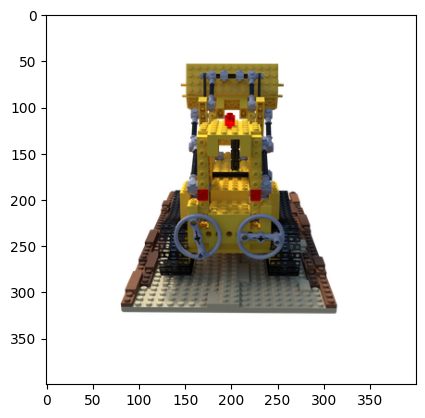

In [68]:
H = 400
W = 400
chunk_size=10
img_index=0
data = [] 

for batch in data_loader:
    ray_origins = batch[:, :3]
    ray_directions = batch[:, 3:6]
    ground_truth_px_values = batch[:, 6:]
    
    print(batch.shape)
    
    ray_origins = training_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = training_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]
    ground_truth_px_values = training_dataset[img_index * H * W: (img_index + 1) * H * W, 6:]

    print(ray_origins.shape)
    print(ray_directions.shape)
    print(ground_truth_px_values.shape)
    print(img_index * H * W)
    print((img_index + 1) * H * W)
    print(training_dataset.shape)
    print(ray_origins)
    print(ray_directions)

    plt.imshow(ground_truth_px_values.reshape(H, W, 3))
    #print(np.sqrt(1024))
    #for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        #print(i)
        # Get chunk of rays
        #ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size]
        #ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size]      
        #regenerated_px_values = ground_truth_px_values[i * W * chunk_size: (i + 1) * W * chunk_size] 
        #data.append(ground_truth_px_values)
    #img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)
    #print(img)
    break

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
(100, 100, 3)


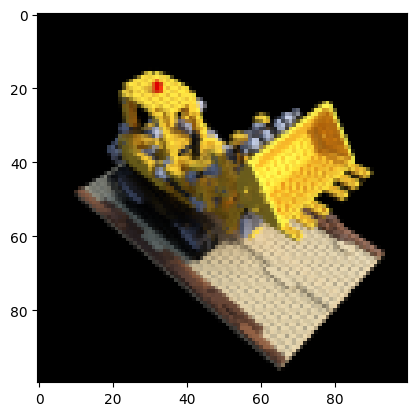

[[-8.4717971e-01  1.4040516e-01 -5.1241869e-01 -2.0656259e+00]
 [-5.3130651e-01 -2.2387907e-01  8.1706268e-01  3.2936852e+00]
 [ 7.4505806e-09  9.6445042e-01  2.6426393e-01  1.0652820e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
(100, 100, 3)


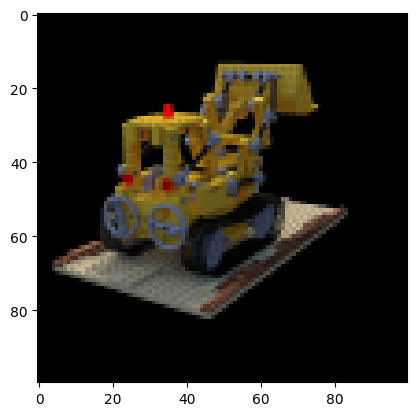

In [2]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)


testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

print(testpose)
#print(poses)
print(testimg.shape)
plt.imshow(testimg)
plt.show()

testimg, testpose = images[51], poses[51]
print(testpose)
#print(poses)
print(testimg.shape)
plt.imshow(testimg)
plt.show()

In [3]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

2023-06-29 14:10:51.325740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-06-29 14:10:51.400723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 14:10:51.402579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-06-29 14:10:51.402633: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-29 14:10:51.409810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-06-29 14:10:51.409912: I tensorflow/stream_executor

0 0.029480199813842773 secs per iter


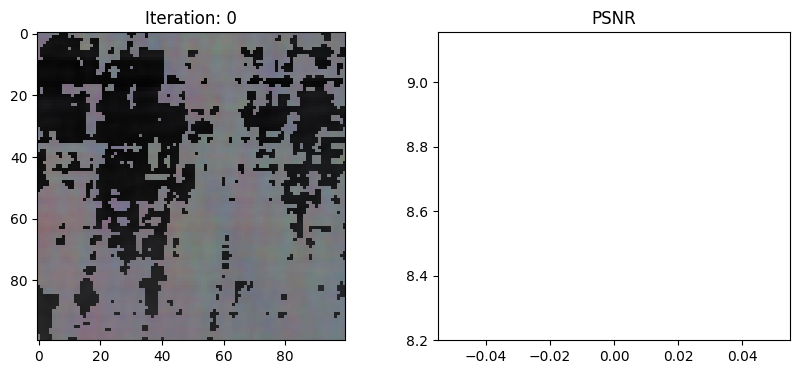

25 0.40488792419433595 secs per iter


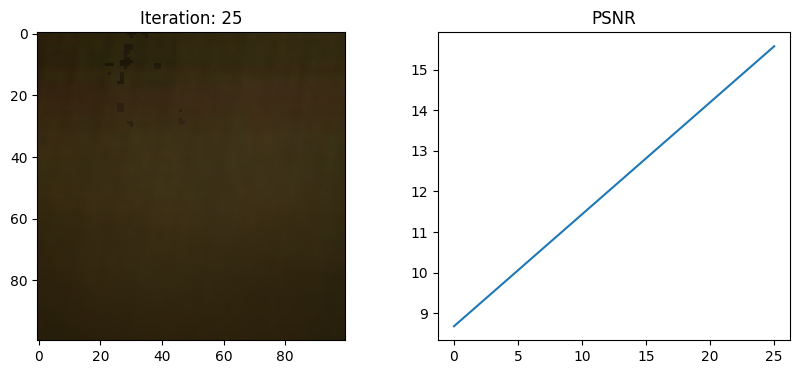

50 0.4256979274749756 secs per iter


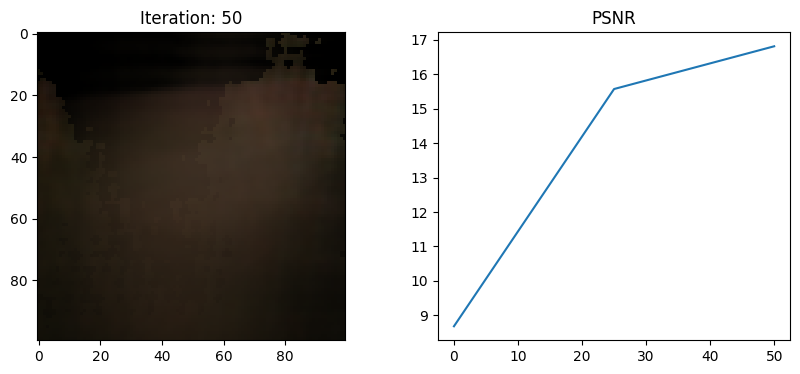

75 0.4241402816772461 secs per iter


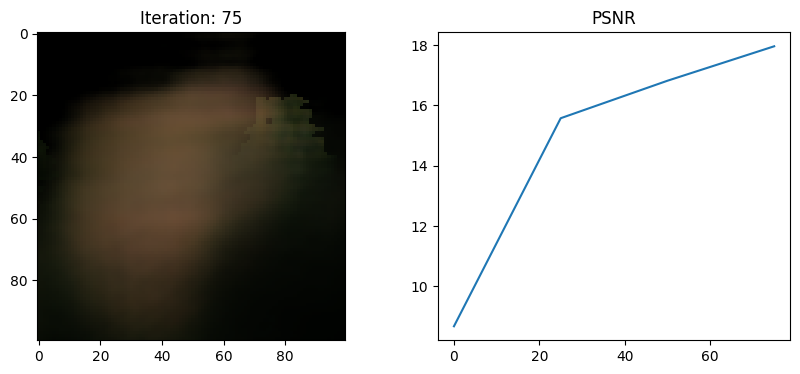

100 0.41881842613220216 secs per iter


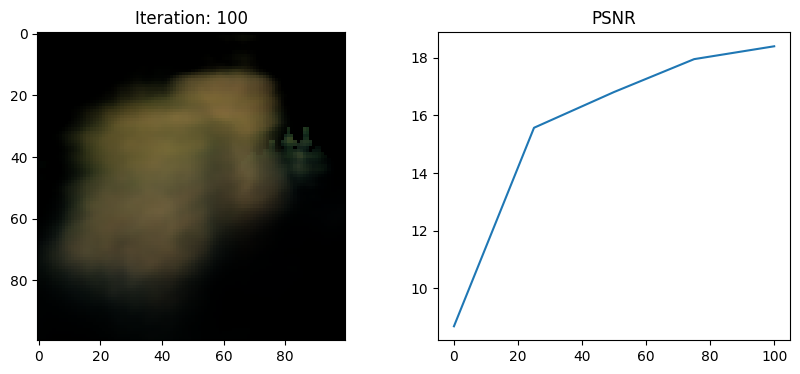

125 0.4285521793365479 secs per iter


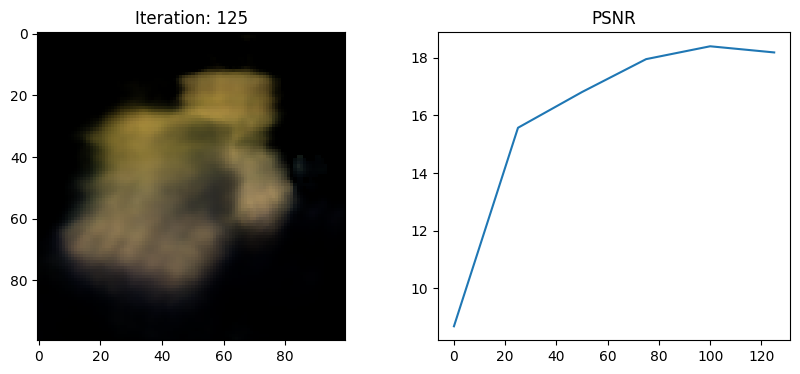

150 0.4239997959136963 secs per iter


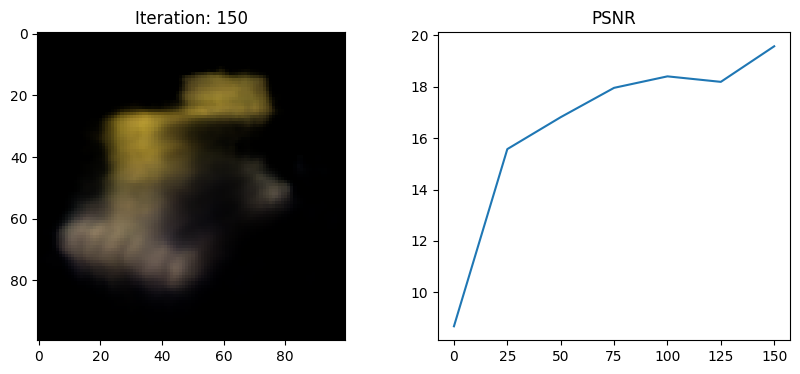

175 0.42333585739135743 secs per iter


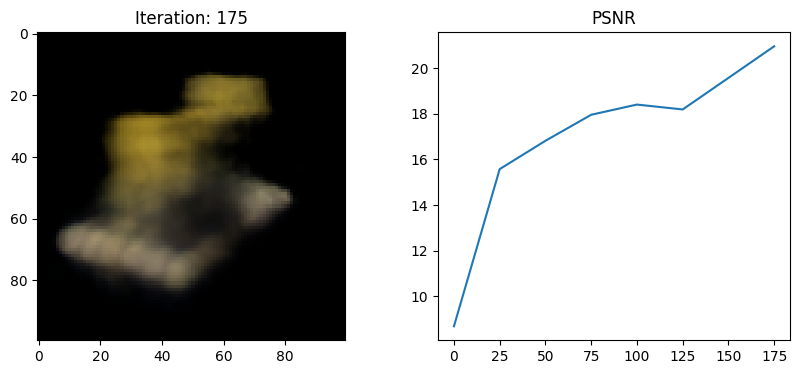

200 0.41576778411865234 secs per iter


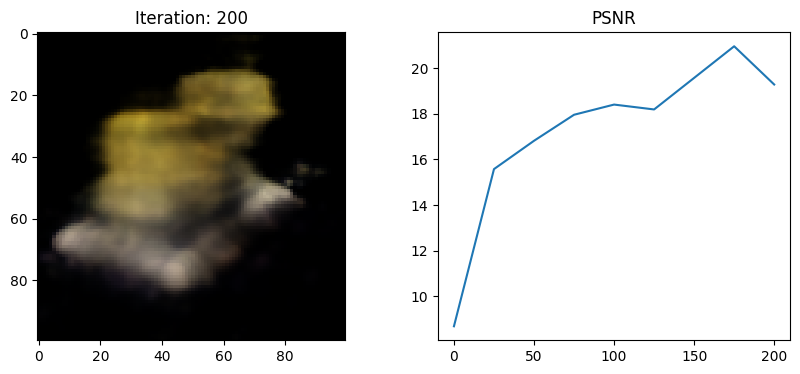

225 0.42696791648864746 secs per iter


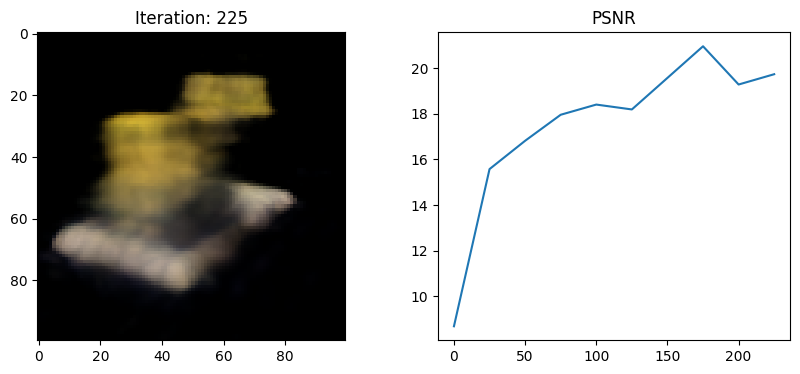

250 0.42666500091552734 secs per iter


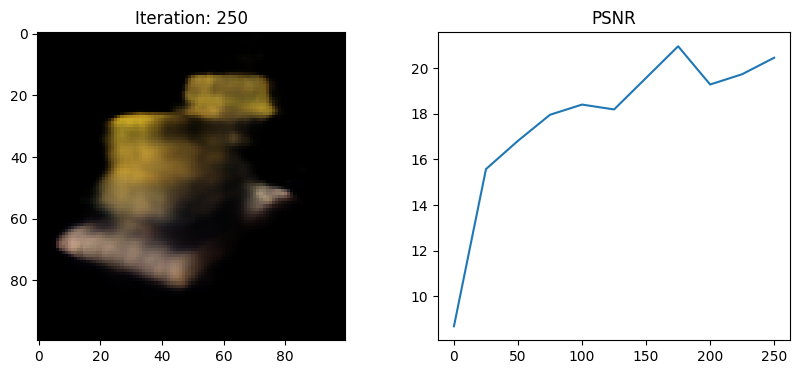

275 0.4263004684448242 secs per iter


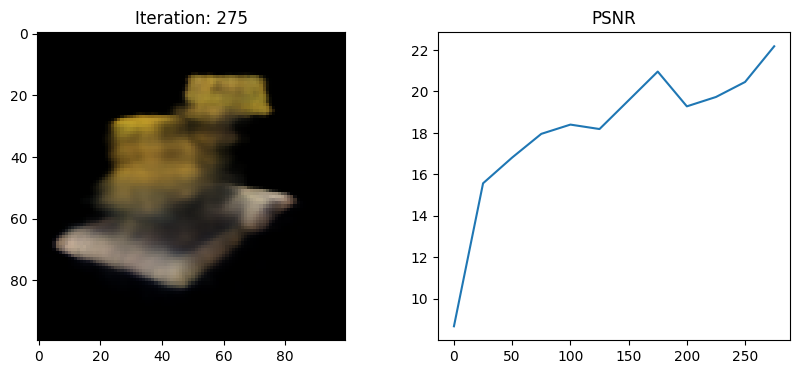

300 0.419205436706543 secs per iter


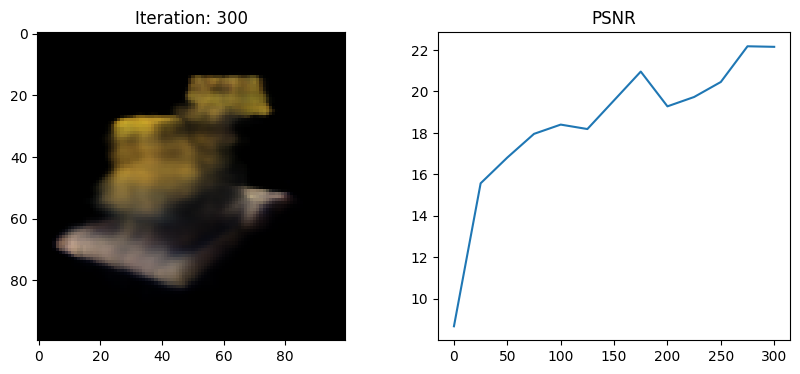

325 0.4210033416748047 secs per iter


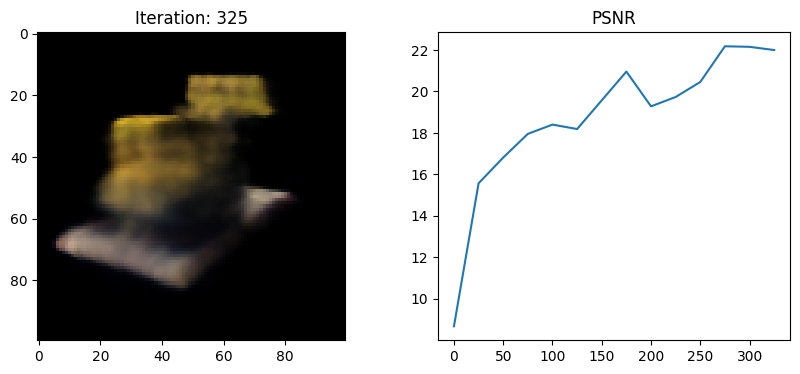

350 0.41947120666503906 secs per iter


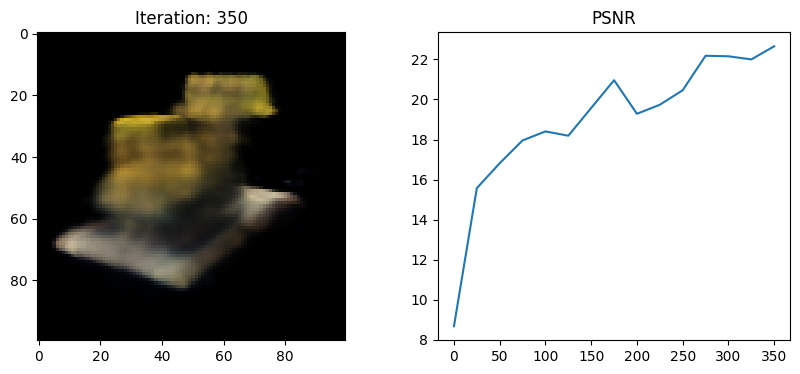

375 0.42471095085144045 secs per iter


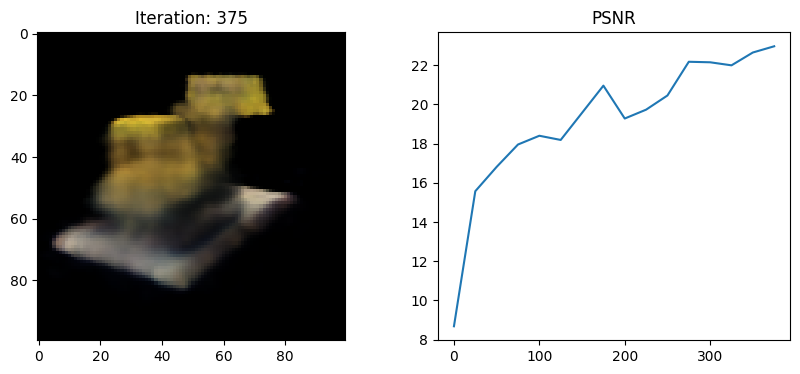

400 0.42200752258300783 secs per iter


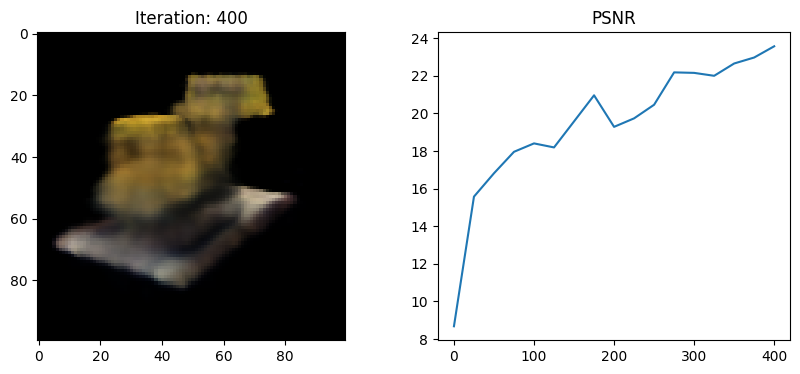

425 0.4248616600036621 secs per iter


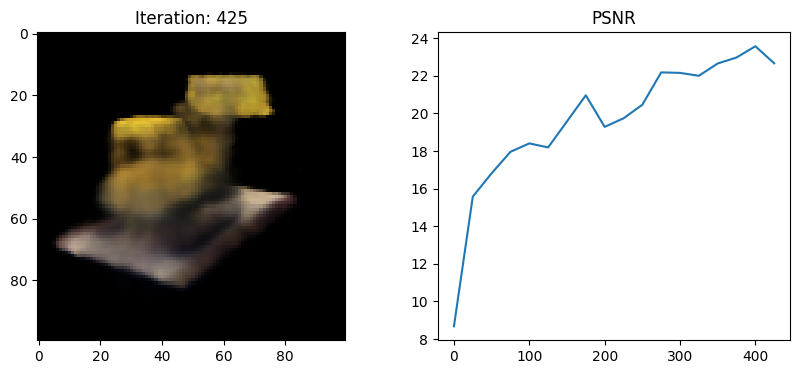

450 0.4244730091094971 secs per iter


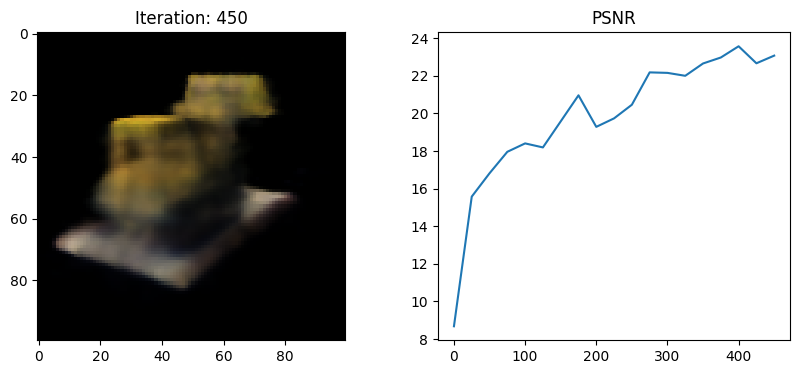

475 0.42059825897216796 secs per iter


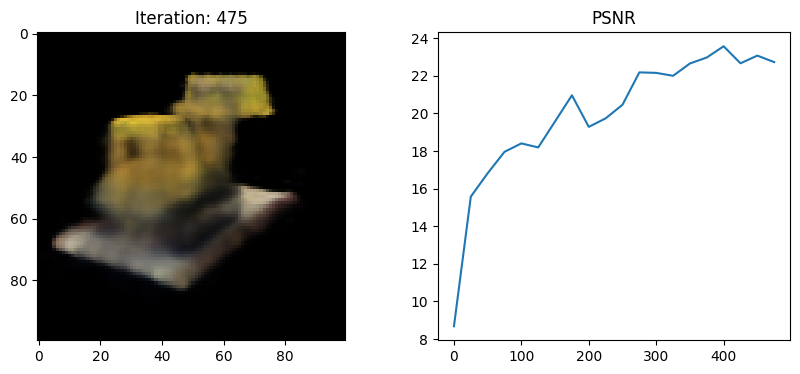

500 0.42475859642028807 secs per iter


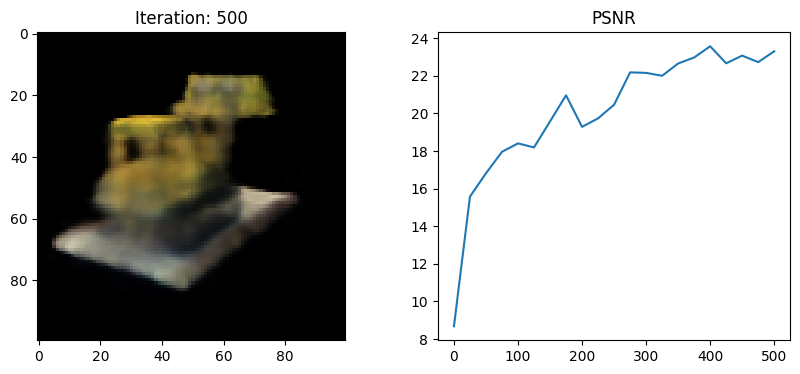

525 0.4275045680999756 secs per iter


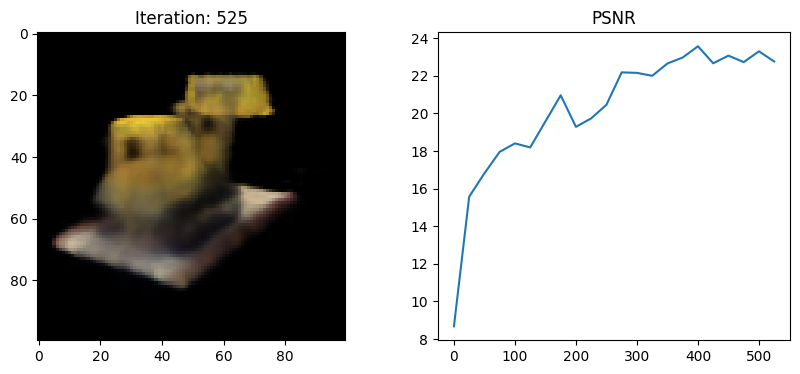

550 0.4289570331573486 secs per iter


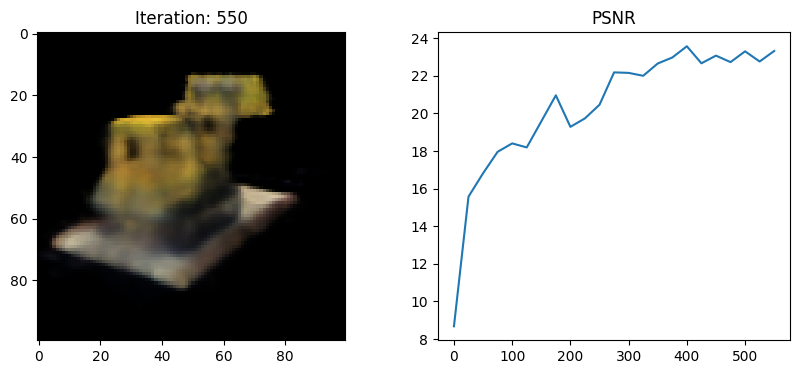

575 0.4298355484008789 secs per iter


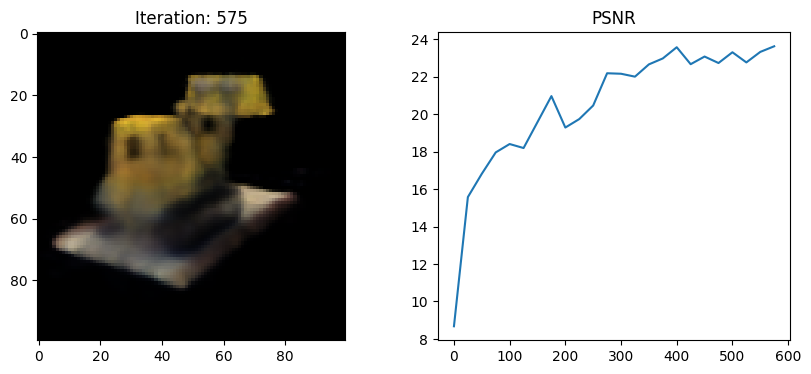

600 0.4429236698150635 secs per iter


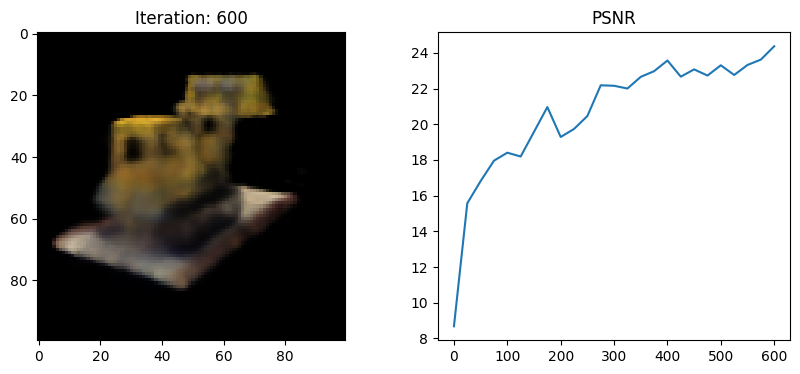

625 0.43738316535949706 secs per iter


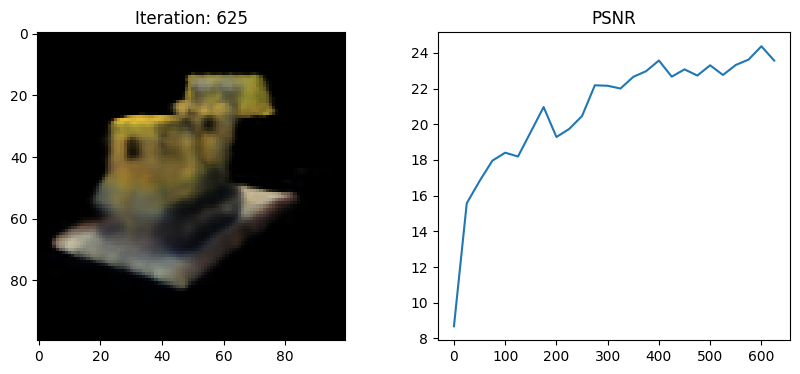

650 0.44257081985473634 secs per iter


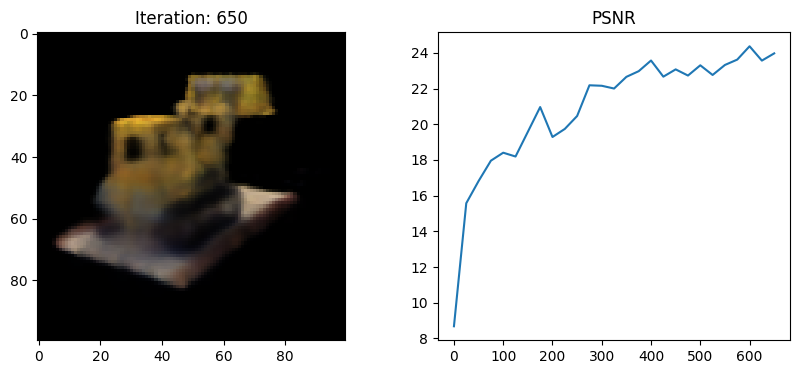

675 0.4362455654144287 secs per iter


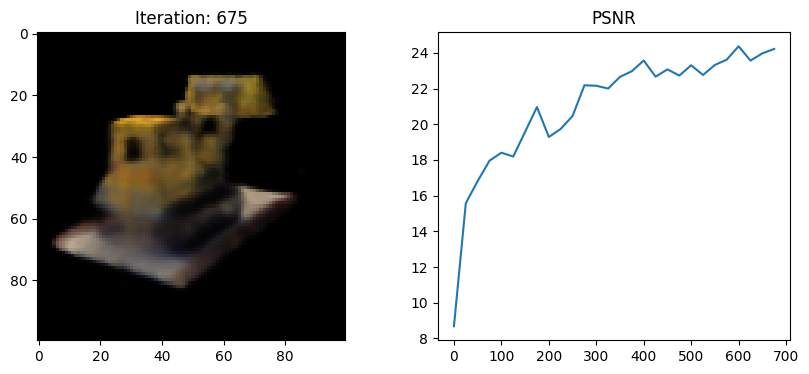

700 0.43741190910339356 secs per iter


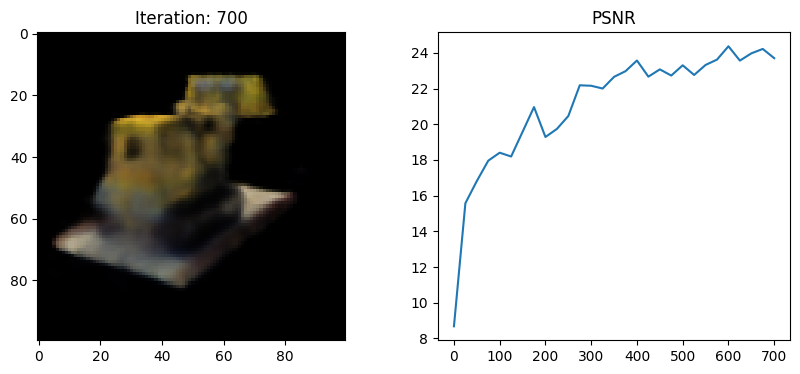

725 0.4504310989379883 secs per iter


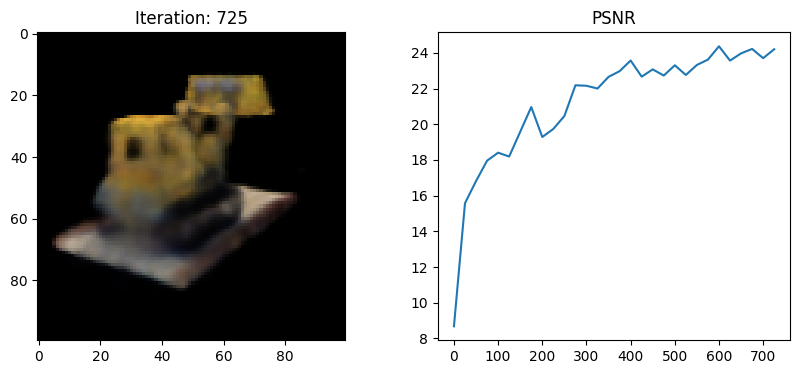

750 0.43323928833007813 secs per iter


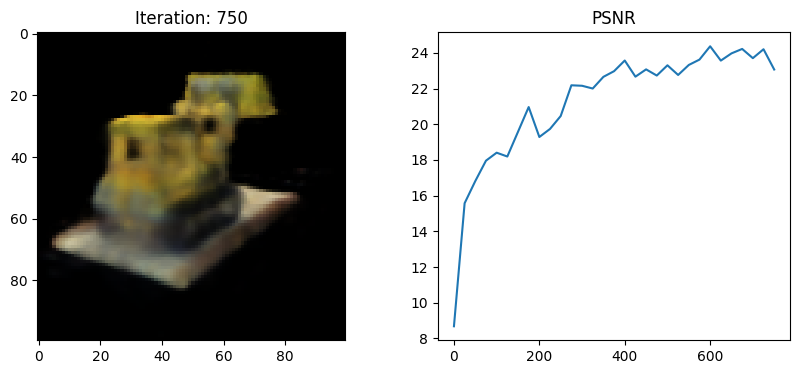

775 0.42121936798095705 secs per iter


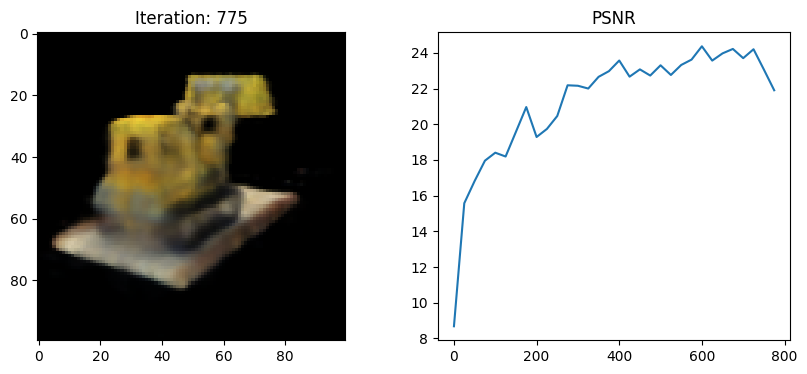

800 0.4296414375305176 secs per iter


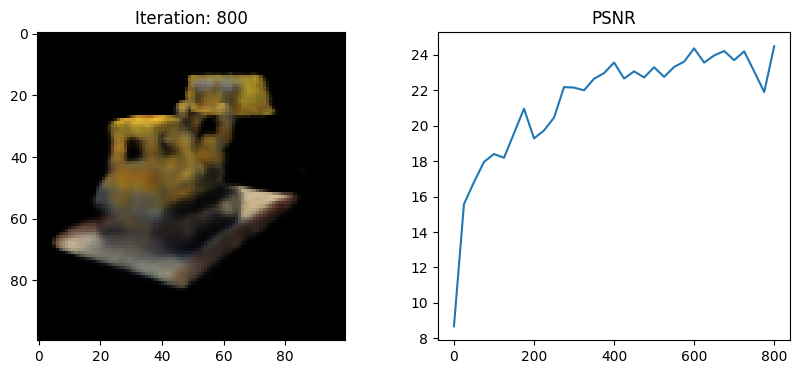

825 0.4349826335906982 secs per iter


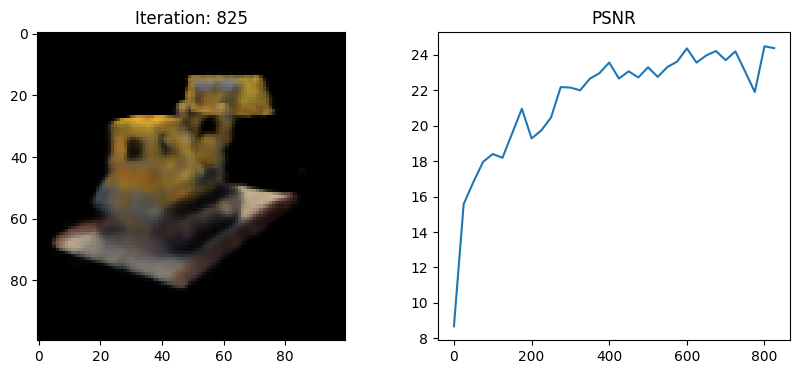

850 0.4265489292144775 secs per iter


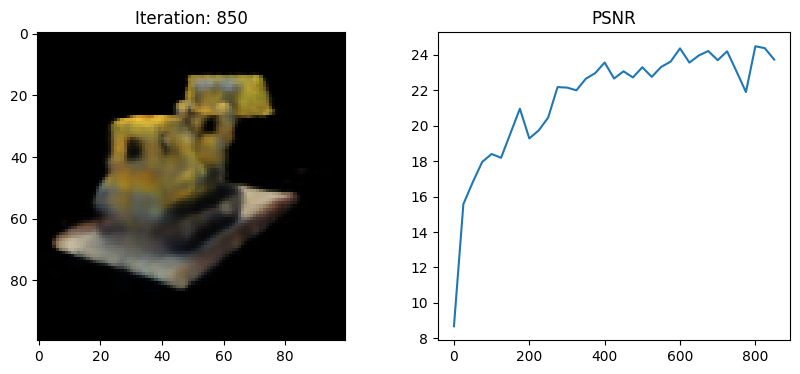

875 0.41690993309020996 secs per iter


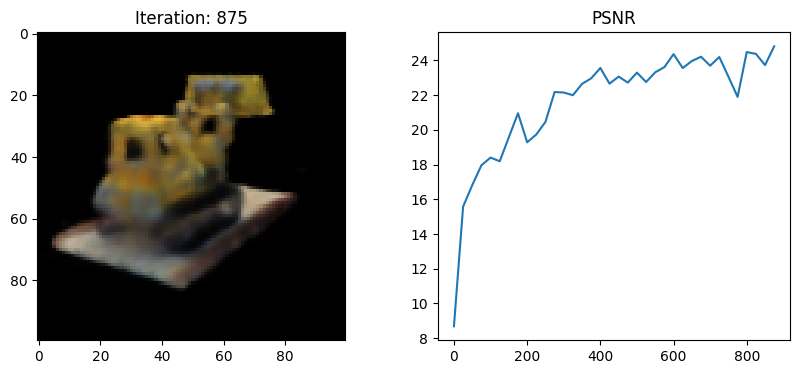

900 0.4268252563476562 secs per iter


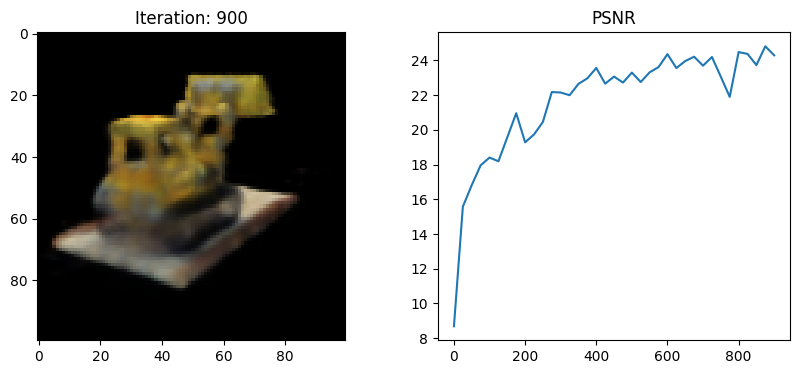

925 0.42420080184936526 secs per iter


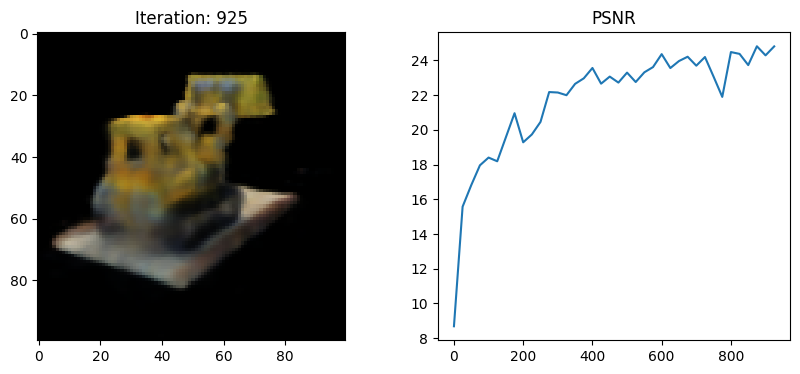

950 0.4308642292022705 secs per iter


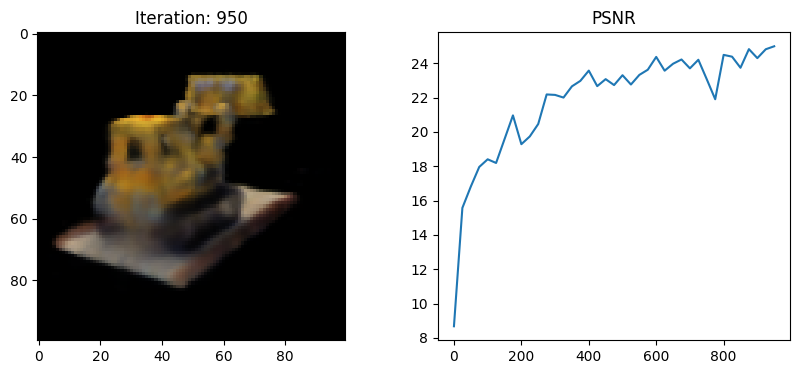

975 0.4371002674102783 secs per iter


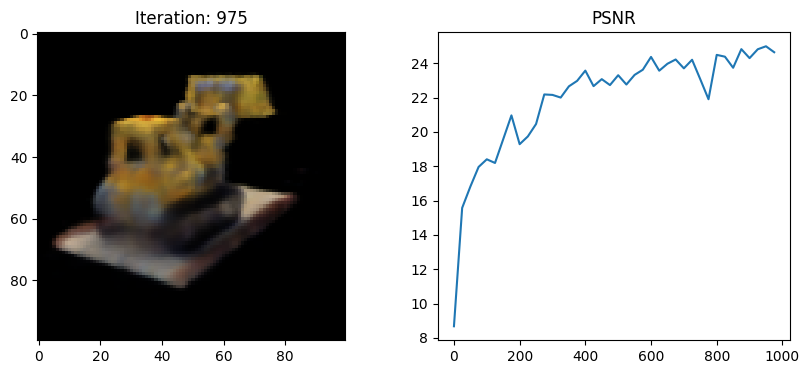

1000 0.4283218574523926 secs per iter


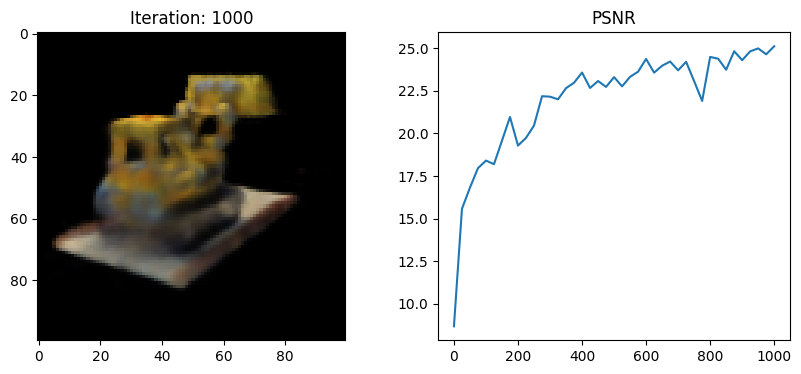

Done


In [4]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [5]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [6]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [7]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)